# Explaining the loss of a model

## Introduction

In theory, SHAP values can be used to explain anything about a machine learning model that can be formulated as the "value of the game" $v(S)$ for a coalition $S$.

Typically, when people talk about using shap explanations on a machine learning model, they refer to explaining the contribution to the prediction output.

There are however many alternative applications in the machine learning literature, including for example **feature selection**, where $v(S)$ is the model performance, **data valuation**, where $v(S)$ is the goodness of fit on test data, or **monitoring**, where $v(S)$ is the model loss.


### Motivation

In this notebook, I will look closer at how shap values can be used to explain the loss of a model. 

In particular, I will be interested in explaining the contribution of each feature/covariate to the MSE at the leaf level of a tree ensemble regression model. This will allow to characterize the hetereogeneity of CATEs within the leafs of the tree ensemble.

### Existing approaches and shortcomings

In the existing implementation of [treeSHAP](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.TreeExplainer.html) in the mainstream package for shap values, `shap`, there is the possibility to compute the `log_loss` of binary classification models, but not more general loss functions. (Note that when computing any loss, one has to pass the label to the shap explainer as well.)

It also mentions that it is possible to pass "the name of a supported prediction method on the model object" for which the shap values will then be computed. Besides raw output and probabilities for classification, however, there are no default methods to get the MSE.

Instead of having to modify the `shap` package, there might be an easy way by creating a wrapper class for our RandomForestRegressor that exhibits a method that returns the leaf node MSE for any observation.

A complication is that this "custom" model output shap explanation is only supported for `feature_perturbation="interventional`, as opposed to the default `feature_perturbation="tree_path_dependent"`, which uses the background training samples that went down each tree path to compute "observational conditional expectations" from which to sample "inactive" features. 

The `interventional` method requires to pass a background dataset (with regards to which runtime scales linearly), and the documentation suggests to use anywhere from 100 to 1000 random background samples. It claims that the `interventional` approach *"breaks the dependencies between features according to the rules dictated by causal inference [(Janzing et al. 2019)](https://proceedings.neurips.cc/paper/2019/file/2172fde49301047270b2897085e4319d-Paper.pdf)"*. It is not yet clear to me how this can be done without integrating any causal knowledge about our Xs into the model - the formulation is probably unfortunate at best. 

The most convincing way I have seen this done is as demonstrated by (Heskes, Bucur, Sijben and Claassen 2020) from Radboud University, which suggest and demonstrate to use Pearls do-calculus to compute interventional conditional distributions, and so naturally asks for a DAG.

In any case, this is important to be aware of. I think one can make a case for being interested in the interpretation that the `interventional` approach, but if not, then there is no way around touching the `shap` package (which might be very difficult).

### Idea behind explaining loss

Let $\Pi$ denote the partition of a fit regression tree, and $l(x, \Pi)$ the leaf node that $x$ falls into under partition $\Pi$.

For each input vector $x_i$, a standard fitted decision tree regressor provides output 
$$
f(x_i) = \frac{1}{\#\{k \in l(x_i, \Pi)\}} \sum_{k \in l(x_i, \Pi)}\bar{Y_k}
$$

Similarly, for each input vector $x$, we can consider the loss at each input vector:

$$
\begin{align*}
\text{loss}(x_i) &= (y-f(x_i))^2 \\
&= (y - \frac{1}{\#\{k \in l(x_i, \Pi)\}} \sum_{k \in l(x_i, \Pi)}\bar{Y_k})^2
\end{align*}
$$

The overall MSE loss of the data is just the average of the squared error at each input vector:
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n \text{loss}(x_i)
$$

These are feasible to compute for any input vector $x_i$ and any partition $\Pi$ since we know the outcome $y_i$ for each collection of covariates in an input vector $x_i$. This will not be the case for CATE in causal trees, for the standard "fundamental problem of causal inference". In that case we will resort to corresponding estimators from our estimation data (Athey & Wager, PNAS 2016).

Let's now see how we can use shap to explain such loss.

### Why is shap contribution to loss not a simple function of contribution to prediction?

One might wonder why the contribution of a particular feature value to the loss is not immediately understood by looking at the contribution of that feature value to the prediction, since the "role" of the feature only plays into f(x) in the squared error formula.
The reason is that it is a nonlinear transformation, which means, by the linearity property of the Shapley value solution concept
$$
\phi(N,v+w) = \phi(N,v) + \phi(N,w) \quad \text{for any games} (N,v) \text{ and } (N,w) \quad\quad \text{(see shap\_intro.ipynb)}
$$
that the contribution to loss cannot be easily disentangled from the distribution to prediction:

\begin{align*}
\text{Squared error}(x_i) &= (y_i-\hat{f}(x_i))^2 \\
&= y_i^2 - 2y_i\hat{f}(x_i) + \hat{f}(x_i)^2 \\
\end{align*}

So whilst scalar shifts or multiplications of the prediction $\hat{f}(x_i)$ is a simple linear transformation of the known contribution to the prediction $\phi(N,\hat{f}(x_i))$ we get for free, the contribution to the squared error is not known and has to be computed on its own:

\begin{align*}
\phi(N, (y_i-\hat{f}(x_i))^2) &= \phi(N, y_i^2 - 2y_i\hat{f}(x_i) + \hat{f}(x_i)^2) \\
&= y_i^2 - 2y_i\phi(N, \hat{f}(x_i)) + \phi(N, \hat{f}(x_i)^2)
\end{align*}

**In other words, we know the contribution to the squared error of an observation as soon as we know the outcome, the contribution to the prediction, and to the prediction squared.**


## Defining a custom tree regressor

Let's now turn to a demonstration of how we can use shap to explain squared loss using the `shap` package. I will begin with an exposition on a single tree.

In [2]:
# imports
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.datasets import load_diabetes

# Load the Diabetes dataset
diabetes = load_diabetes()

# create joint dataframe
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df['target'] = diabetes.target

df.shape


(442, 11)

In [4]:
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


I now define a custom tree regressor class that extends the standard sklearn model for a simple method that computes the squared loss for each observation, and can be used similar to a `.predict()` method.

In [5]:
# define a new estimator with our new custom loss

class CustomDecisionTree(DecisionTreeRegressor):
    def __init__(
        self,
        *,
        criterion="squared_error",
        splitter="best",
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features=None,
        random_state=None,
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        ccp_alpha=0.0,
    ):
        super().__init__(
            criterion=criterion,
            splitter=splitter,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf,
            max_features=max_features,
            max_leaf_nodes=max_leaf_nodes,
            random_state=random_state,
            min_impurity_decrease=min_impurity_decrease,
            ccp_alpha=ccp_alpha,
        ) # setting them all this way respects the scikit-learn demanded init structure
    
    def leaf_mean_loss(self, X, y):
        """
        Computes the squared loss between the outcome and the mean value of the leaf node to which x traverses through the partition.

        Parameters:
            X (array-like or sparse matrix): Input samples.

        Returns:
            array-like: Array of squared errors between the predicted values and the mean value of the leaf nodes.
        """
        # check that tree is fitted
        assert self.tree_ is not None

        # return squared loss
        sq_loss = (y - self.predict(X))**2
        
        return sq_loss




Let's try to train our custom tree on the diabetes dataset.

In [6]:
# instantiate GridSearchCV
grid = GridSearchCV(
    estimator=CustomDecisionTree(),
    param_grid={'max_depth': np.arange(2, 10)},
    cv = 4)
grid.fit(df.drop("target",axis = 1), df.target)

# get the best estimator
best_estimator = grid.best_estimator_

# get the best parameters
grid.best_params_

{'max_depth': 2}

In [7]:
# compute the loss for each observation
loss = best_estimator.leaf_mean_loss(df.drop("target",axis = 1), df.target)

In [8]:
# lets check this adds up to the MSE
print(np.sum(loss) / len(loss))
print(mean_squared_error(df.target, best_estimator.predict(df.drop("target",axis = 1))))

3360.050096675736
3360.050096675736


Having now defined a custom loss function, we should be able to use default shap code to explain the loss of our model using our model method name using the `model_output = 'leaf_mean_loss'` argument, as explained in their [documentation](https://shap-lrjball.readthedocs.io/en/latest/generated/shapTreeExplainer.html).

### SHAP explanations

(NOTE: Deprecations in numpy 1.23 -> 1.24 have caused some issues in the shap package, see [here](https://github.com/shap/shap/issues/2911). It is best to go with numpy 1.23 and shap 0.42)

#### SHAP for predictions

Let's first compute the standard "prediction" shap explanation on our diabetes data using our custom tree regressor.

In [9]:
import shap
print(shap.__version__)

# compute SHAP values
explainer = shap.TreeExplainer(best_estimator)
prediction_shap_values = explainer(df.drop("target",axis = 1))

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


0.42.1


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


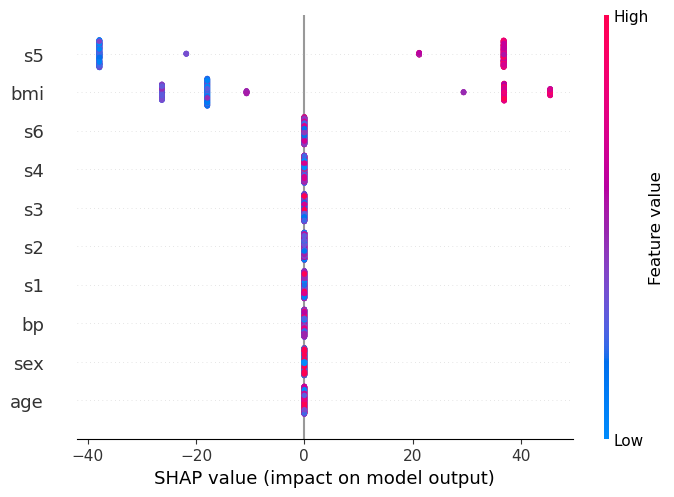

In [10]:
# make beeswarm plot of shap values
shap.plots.beeswarm(prediction_shap_values)

We can see that only BMI and s5 have any influence on the predictions.

#### SHAP for loss using "model method name"

In [11]:
# now we specify our custom loss function

loss_explainer = shap.TreeExplainer(best_estimator, df.drop("target",axis = 1), feature_dependence="independent", model_output="leaf_mean_loss")
loss_shap_values = loss_explainer.shap_values(df.drop("target",axis = 1), df.target)

feature_dependence = "independent" has been renamed to feature_perturbation = "interventional"! See GitHub issue #882.


ExplainerError: Currently TreeExplainer can only handle models with categorical splits when feature_perturbation="tree_path_dependent" and no background data is passed. Please try again using shap.TreeExplainer(model, feature_perturbation="tree_path_dependent").

**What is happening here?**

Unrecognized parameter value: leaf_mean_loss... Even though it is a well defined model method name. So it seems that the documentation is a bit misleading here.

I checked the source code, and found out that the model method name is actually simply not implemented.

Because the output predictions are computed using a tree in the C-extension, these arguments are not actually passed to the python model, so one has to translate this for adapter to the C-extension.

I opened a [issue on github](https://github.com/shap/shap/issues/3420) to ask how this could be done.

### *a cheap workaround (just for my memory...)?*

[Update]: Reading the [shap source code](https://github.com/shap/shap/blob/d534ef30e33d21672b22addee245a3f3e6dd23e0/shap/explainers/_tree.py#L1238-L1273) I tried some cheap workarounds here, but they didn't work.

Reading the source-code, I discovered that this adapter is pretty messy. Glancing over, it seems that if you pass "log_loss" and the criterion is "squared_error", the transform passed to the c-extension is "squared_loss". Would this give you the MSE?

(from the source)
```python
    elif self.model_output == "log_loss":
        if self.objective == "squared_error":
            transform = "squared_loss"
```

Let's see if this actually works

In [ ]:
loss_explainer = shap.TreeExplainer(best_estimator, df.drop("target",axis = 1), model_output="log_loss")
loss_shap_values = loss_explainer(X = df.drop("target",axis = 1), y=df.target)

NotImplementedError: model_output = "log_loss" is not yet supported when model.objective = "None"!

For some reason model.objective is not set to our criterion (squared_error, see below)... Is this just because we are a custom model that the shap explainer does not know about?

(again, from .tree source)
```python
[...]
elif safe_isinstance(
    model,
    [
        "sklearn.tree.DecisionTreeRegressor",
        "sklearn.tree.tree.DecisionTreeRegressor",
        "econml.grf._base_grftree.GRFTree",
    ],
):
    self.internal_dtype = model.tree_.value.dtype.type
    self.input_dtype = np.float32
    self.trees = [SingleTree(model.tree_, data=data, data_missing=data_missing)]
    self.objective = objective_name_map.get(model.criterion, None)
    self.tree_output = "raw_value"
```

In [ ]:
type(best_estimator)

__main__.CustomDecisionTree

In [ ]:
best_estimator.criterion

'squared_error'

so lets go back to a basic tree and see if we can get it to work using the log_loss argument to get the squared loss

In [ ]:
# train standard decision tree

gscv = GridSearchCV(
    estimator=DecisionTreeRegressor(),
    param_grid={'max_depth': np.arange(2, 10)},
    cv = 4)

gscv.fit(df.drop("target",axis = 1), df.target)

best_tree = gscv.best_estimator_

In [ ]:
# get treeshap explainer

tree_explainer = shap.TreeExplainer(best_tree, df.drop("target",axis = 1), feature_dependence="independent", model_output="log_loss")
shape_values = tree_explainer.shap_values(df.drop("target",axis = 1), df.target)

feature_dependence = "independent" has been renamed to feature_perturbation = "interventional"! See GitHub issue #882.


NotImplementedError: model_output = "log_loss" is not yet supported when model.objective = "None"!

No... It checks that we are not a classification model.

In [ ]:
# try with clasisfication
from sklearn.tree import DecisionTreeClassifier

# define binary y as target over target.mean()

df['target_binary'] = (df.target > df.target.mean()).astype(int)

# train classifier

gscv = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid={'max_depth': np.arange(2, 10)},
    cv = 4)

gscv.fit(df.drop(["target", "target_binary"],axis = 1), df.target_binary)

best_clf = gscv.best_estimator_


In [ ]:
# get ACTUAL log loss by using a classifier

explainer = shap.TreeExplainer(best_clf, df.drop(["target", "target_binary"],axis = 1), feature_dependence="independent", model_output="log_loss")
explainer.shap_values(df.drop(["target", "target_binary"],axis = 1), df.target_binary)

feature_dependence = "independent" has been renamed to feature_perturbation = "interventional"! See GitHub issue #882.


[array([[ 0.        ,  0.        , -0.10934881, ...,  0.        ,
         -0.11823457,  0.        ],
        [ 0.        ,  0.        ,  0.11022653, ...,  0.        ,
          0.12788771,  0.        ],
        [ 0.        ,  0.        , -0.10934881, ...,  0.        ,
         -0.11823457,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.11022653, ...,  0.        ,
          0.12788771,  0.        ],
        [ 0.        ,  0.        ,  0.07238968, ...,  0.        ,
          0.0747089 ,  0.        ],
        [ 0.        ,  0.        ,  0.11022653, ...,  0.        ,
          0.12788771,  0.        ]]),
 array([[ 0.        ,  0.        ,  0.11646402, ...,  0.        ,
          0.12153013,  0.        ],
        [ 0.        ,  0.        , -0.09942289, ...,  0.        ,
         -0.11848999,  0.        ],
        [ 0.        ,  0.        ,  0.11646402, ...,  0.        ,
          0.12153013,  0.        ],
        ...,
        [ 0.        ,  0.        , -0.09942289, ...,  

So it might be that this workaround could nevertheless work if we only play around with how the instance attributes are set in the shap implementation of the tree within the shap explainer, if it is true that the underlying C-extension is set up to compute the MSE when the criterion is "squared_error" and the model_output is "log_loss"... In any case the the shap code needs to be fixed or the documentation adjusted...

